# Future Prediction on Exercise Datasets

In [1]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Load Data

### Train

In [2]:
exe_train = get_collection("../data/exercise-128x128/train")
total_train = sum([x.shape[0] for x in exe_train])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(exe_train), total_train))

{'images:': 'Exercise-Train-01', 'dim': (3442, 128, 128, 3)}
{'images:': 'Exercise-Train-02', 'dim': (7134, 128, 128, 3)}
{'images:': 'Exercise-Train-03', 'dim': (7710, 128, 128, 3)}
{'images:': 'Exercise-Train-04', 'dim': (4646, 128, 128, 3)}
{'images:': 'Exercise-Train-05', 'dim': (5258, 128, 128, 3)}
{'images:': 'Exercise-Train-06', 'dim': (5304, 128, 128, 3)}
{'images:': 'Exercise-Train-07', 'dim': (4488, 128, 128, 3)}
{'images:': 'Exercise-Train-08', 'dim': (7050, 128, 128, 3)}
{'images:': 'Exercise-Train-09', 'dim': (4838, 128, 128, 3)}
{'images:': 'Exercise-Train-10', 'dim': (4874, 128, 128, 3)}
{'images:': 'Exercise-Train-11', 'dim': (5446, 128, 128, 3)}
{'images:': 'Exercise-Train-12', 'dim': (4772, 128, 128, 3)}
{'images:': 'Exercise-Train-13', 'dim': (8560, 128, 128, 3)}
{'images:': 'Exercise-Train-14', 'dim': (4726, 128, 128, 3)}
{'images:': 'Exercise-Train-15', 'dim': (2822, 128, 128, 3)}
{'images:': 'Exercise-Train-16', 'dim': (4394, 128, 128, 3)}
{'images:': 'Exercise-Tr

### Test

In [3]:
exe_test = get_collection("../data/exercise-128x128/test/")
total_test = sum([x.shape[0] for x in exe_test])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(exe_test), total_test))

{'images:': 'Exercise-Test-12', 'dim': (1000, 128, 128, 3)}

After Augmentation: img_collections has 1 collections, 1000 images in total


# Sample 

In [4]:
def sample(collection, batch_size = 8):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img - [batch size, 32, 32]
    """
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = 2 * int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(0, num_per_collection[i] - 1, 2), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+1 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    assert len(before_imgs) == batch_size
    assert len(after_imgs) == batch_size
    return before_imgs, after_imgs


def sample_train(batch_size = 8): return sample(exe_train, batch_size)

def sample_test(batch_size = 8):  return sample(exe_test, batch_size)

### Sample Training Data 

Range of Image Piece Value: [0, 255]
Before: (6, 128, 128, 3)
After:  (6, 128, 128, 3)


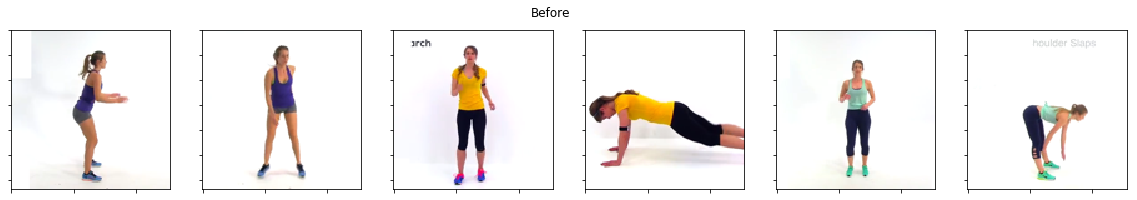

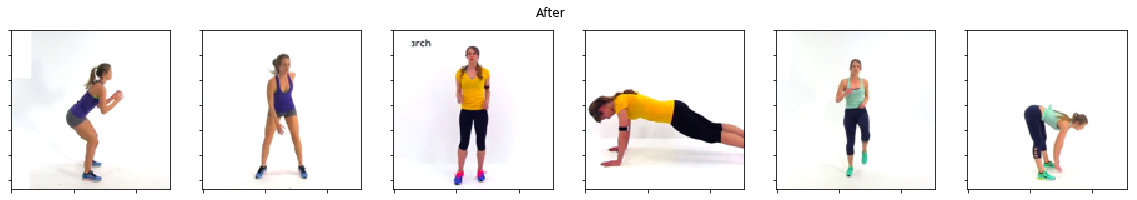

In [5]:
def show_sample_train(batch_size):
    before, after = sample_train(batch_size=batch_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(before), np.max(before)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    size = (20, 3)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 6)

### Sample Test Data

Range of Image Piece Value: [0, 255]
Before: (6, 128, 128, 3)
After:  (6, 128, 128, 3)


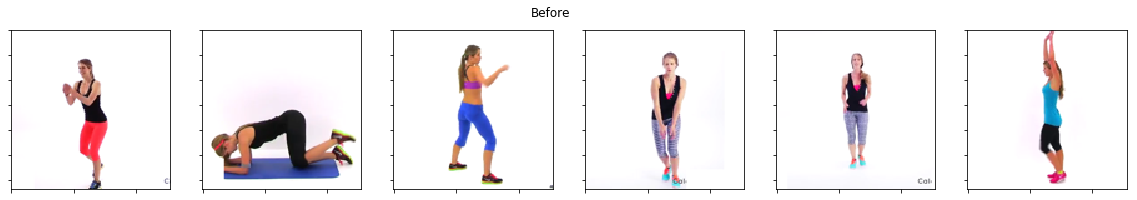

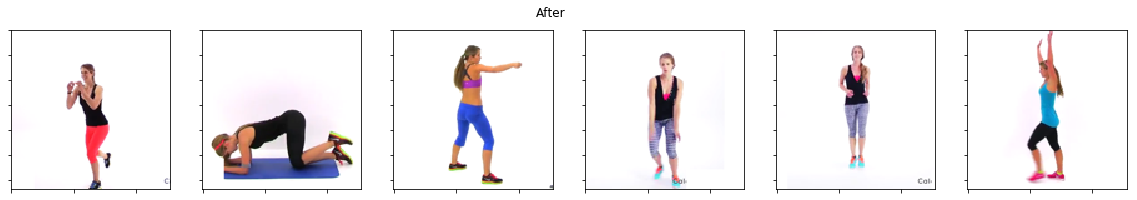

In [6]:
def show_sample_test(batch_size):
    before, after = sample_test(batch_size=batch_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(before), np.max(before)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    size = (20, 3)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    
show_sample_test(batch_size = 6)

# Param

In [7]:
feature_channel = 32

batch_size = 1

learning_rate = 1e-3

beta = 0.9 # defalut 0.9 for adam
num_iteration = 1000

# Idea

Given an image about current configuration, we want to predict the next configuration.
All operations should be done in feature space.

- Encoder: takes an image, output its feature map
- Decoder: takes a feature map, output an image

- Generator: takes the feature map of current configuration, as well as a random noicie, output the feature map for next frame
- Discriminator: takes two feature map about current configuration and next configuration, give a score

# Encoder

In [8]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img [?, 128, 128, 3]
    Output:
        batch size of feature [?, 16, 16, feature_channel]
    """
    x = img
    
    x = tf.layers.conv2d(x, filters = 16, kernel_size=8, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 32, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    return x

# Decoder

In [9]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 16, 16, feature_channel]
    Output:
        batch size of img [batch_size, 128, 128, 3]
    """
    x = feature
    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters = 64, kernel_size=3, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=7, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3,  strides=1, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=3, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

# Loss

In [10]:
def gan_loss(logits_real, logits_fake):
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits = logits_fake)
    
    D_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits = logits_real)\
     +  tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits = logits_fake)
        
    G_loss = tf.reduce_mean(G_loss)
    D_loss = tf.reduce_mean(D_loss)
    return D_loss, G_loss

# Discriminator

In [11]:
def discriminate(feature1, feature2):
    """
    Input:
        two feature map [?, 16, 16, feature_channels]
    Output:
        a score about probability of such transition
    """
    with tf.variable_scope("discriminator"):
        x = tf.concat([feature1, feature2], axis=3)
        x = tf.layers.conv2d(x, filters=32, kernel_size=5, activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 64, kernel_size=3, activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 128, kernel_size=2, activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64, activation = tf.nn.relu)
        logits = tf.layers.dense(x, 1)
        return logits

In [12]:
def sample_noise(batch_size):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, 16, 16, feature_channel), minval = -1, maxval = 1)

# Generator

In [13]:
def generate(curr_img,  is_training=True, batch_size = batch_size):
    """
    Input:
        curr_img: batch size of image features
    Output:
        predicted image features of batch size
    """
    z = sample_noise(batch_size) # in feature space
    with tf.variable_scope("generator"):
        x    = tf.concat([curr_img, z], axis=3)
        x    = tf.layers.conv2d(x, filters = 16, kernel_size=7, padding='same', activation=tf.nn.relu)
        x    = tf.layers.conv2d(x, filters = 32, kernel_size=5, padding='same', activation=tf.nn.relu)
        x    = tf.layers.conv2d(x, filters = 64, kernel_size=3, padding='same', activation=tf.nn.relu)
        x    = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
        img  = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
        return img

## Solvers

In [14]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

# Computational Graph

In [15]:
tf.reset_default_graph()
batch_before       = tf.placeholder(tf.float32, [None, 128, 128, 3], "batch_before")
batch_after        = tf.placeholder(tf.float32, [None, 128, 128, 3], "batch_after")
is_training        = tf.placeholder(tf.bool, (), name = "is_training")

feature_before     = encode(batch_before)
feature_after      = encode(batch_after)

with tf.variable_scope("") as scope:
    feature_generated  = generate(feature_before)
    G_batch            = decode(feature_generated)

with tf.variable_scope("") as scope:
    logic_real     = discriminate(feature_before, feature_after)
    scope.reuse_variables()
    logic_fake     = discriminate(feature_before, feature_generated)

G_solver, D_solver = get_solvers(learning_rate, beta)

G_vars             = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
D_vars             = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 

D_loss, G_loss     = gan_loss(logic_real, logic_fake)
D_train_step       = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step       = G_solver.minimize(G_loss, var_list=G_vars)

In [16]:
def train(sess, G_step, G_loss, D_train_step, D_loss, batch_size, num_iteration, plot_every = 400, \
          show_loss_every=400, nPlot=6, num_plot = 6, save_every = 1000):
    g_losses, d_losses = [], []
    for i in range(1, num_iteration+1):
        before, after = sample_train(batch_size=batch_size)
        dic = {batch_before: before, batch_after: after, is_training: True}
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        _, D_loss_curr = sess.run([D_train_step, D_loss], dic)
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
        d_losses.append(D_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | D_loss = {}".format(i, G_loss_curr, D_loss_curr))
            
        if i%plot_every == 0:
            before, after = sample_train(batch_size = batch_size)
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: before, batch_after: after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} ".format(i))
    return g_losses, d_losses

# Train! 

Iteration 100:  G_loss = 6567.115745544434 | D_loss = 6.977968692779541


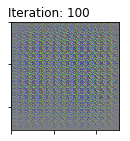

Iteration 200:  G_loss = 23037.70294189453 | D_loss = 0.007283834740519524


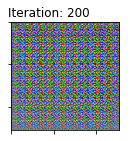

Iteration 300:  G_loss = 2632.084593772888 | D_loss = 0.00021649136033374816


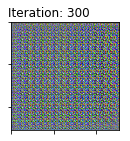

Iteration 400:  G_loss = 15771.41206741333 | D_loss = 7.411743996321718e-10


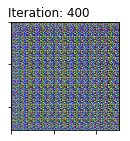

Iteration 500:  G_loss = 858.8734459877014 | D_loss = 0.0011877837823703885


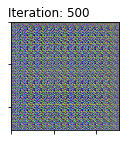

Iteration 600:  G_loss = 888.5909521579742 | D_loss = 0.0009407149627804756


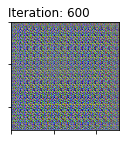

Iteration 700:  G_loss = 993.0734896659851 | D_loss = 0.00041443080408498645


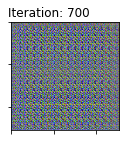

Iteration 800:  G_loss = 782.5756680965424 | D_loss = 0.0021619005128741264


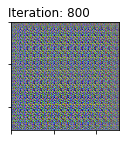

Iteration 900:  G_loss = 900.3633284568787 | D_loss = 0.000857710256241262


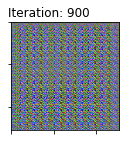

Iteration 1000:  G_loss = 973.6413931846619 | D_loss = 0.00048267748206853867


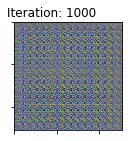

In [17]:
sess           = get_session()
sess.run(tf.global_variables_initializer())
g_loss, d_loss = train(sess, G_train_step, G_loss, D_train_step, D_loss, batch_size, \
               num_iteration, plot_every = 100, show_loss_every = 100, num_plot=4, save_every = 2000)